# Proyecto

In [1]:
#1. Como primer paso partimos de instalar las librerías necesarias para este proyecto, las cuales aparecen a continuación:
import esda 
import pandas as pd
import geopandas as gpd
import libpysal as lps
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from shapely.geometry import MultiPolygon, Polygon
from json import loads

In [273]:
# Creamos una función que genere los polígonos de la CDMX con la información que necesitamos, mediante un método constructor que genera "objetos" para este caso práctico nuestro objeto son los polígonos, los cuales son formas geométricas que delimitan la forma que tienen las delegaciones. A estos objetos les corresponde información contenida en la base de datos predial; es decir, a la información predial de Tlalpan (atributos) le asignamos un polígono (objeto)  

def csv2shp (df): #Definimos la función como "csv2shp"
    pols=[] #creamos una lista vacia que almacenara los poligonos
    for i in df.geo_shape: #Creamos un ciclo iterativo que genera la información de los polígonos que irán a la lista antes mencionada 
        pol=loads(i)['coordinates'][0] #Creamos una variable llamada "pol" que almacenara las coordenadas de los polígonos, esto es importante porque vuelve la información espacial. 
        if len(pol)<2: #Usamos if para el ciclo y quiere decir que en tanto se tengan menos de 2 polígonos se concretara el proceso de extraer las coordenadas para esa geometría   
            pols.append(Polygon(pol[0])) #Polygon es un método constructor de la librería "shapely.geometry"
        else: #Else le indica al programa que hacer en caso de que se encuentre un multipoligono  
            multis= [] #Es una lista vacía que almacenara aquellas geometrías que se compongan de polígonos compuestos de varias geometrías a lo cual llamamos multipoligono  
            for j in pol: #ciclo para los multipoligonos 
                multis.append(Polygon(j)) #Implementa el método constructor en los multipoligonos 
            pols.append(MultiPolygon(multis)) #Añade los multipoligonos procesados a la lista de polígonos para tener nuestros datos completos 

    df['geometry']= pols #En la tabla que construimos llamada "df" almacenamos los datos procesados en el paso anterior  
    gdf= gpd.GeoDataFrame(df,crs='EPSG:4326').drop(columns='geo_shape') #Creamos una variable llamada gdf que almacenará la proyección geográfica asignada a los datos en la tabla df
    
    return gdf #Regresa los datos procesados en la forma deseada 

In [274]:
def predio2ageb(cat,agebF):
    cat['geometry']=cat.geometry.representative_point()
    preRes=gpd.sjoin(agebF,cat).reset_index(drop=True).drop(columns=['index_right','fid','codigo_pos','colonia_pr','CVE_MUN'])
    preRes=preRes.groupby('CVEGEO')[['superficie','anio_const','valor_unit']].mean().reset_index()
    res= pd.merge(preRes, agebF[['CVEGEO','geometry']], on='CVEGEO')
    res.crs = cat.crs
    
    return res

### Crear archivos shp con datos catastrles a nivel predio CDMX

In [275]:
#Para crear el mapa que nos muestre los valores prediales de la cdmx no contamos con datos que nos proporcione directamente esta información, pero podemos construir los datos a partir de dos conjuntos, uno que nos da la información espacial (geografica) y el otro nos da la base de datos de los valuos prediales.
#Creamos una variable llamada csv para almacenar todos los archivos csv (contienen la información predial) esto debido a que se tiene un archivo csv por cada delegación
csv= glob('Data/*.csv')

In [ ]:
for i in tqdm(csv): #Creamos un ciclo para dar tratamiento a los datos en crudo, lo que se hizo fue extraer los datos que nos sirven para el proyecto e indicar el tipo de dato que es; es decir diferenciar entre los valores que son palabras y  los que son números, es importante ya que así podremos realizar operaciones matemáticas. 
    df= pd.read_csv(i, usecols= ['fid','codigo_postal','superficie_terreno','valor_unitario_suelo','geo_shape','colonia_predio','anio_construccion'],
                    dtype= {'fid':str,'codigo_postal':str,'superficie_terreno':float,'valor_unitario_suelo':float,'geo_shape':str,'colonia_predio':str,'anio_construccion':float})

    df= df[~df.geo_shape.isna()].copy() #Elimina aquellos datos que carecen de información espacial

    gdf= csv2shp(df).to_crs('EPSG:32614') #Asignamos la proyección geografica correspondiente a la zona utm de la CDMX

    gdf.to_file('Data/Outputs/{}.shp'.format(i[i.find('mx_')+3:i.find('_08')].replace(" ","_"))) #Indicamos que los resultados obtenidos deben almacenarse en un archivo llamado "Outputs"

 12%|██████████▍                                                                        | 2/16 [01:50<12:19, 52.85s/it]

### Juntar con archivos AGEB 

In [ ]:
ageb= gpd.read_file('Data/conjunto_de_datos/09a.shp')[['CVEGEO','geometry','CVE_MUN']] #Creamos una variable llamada ageb que almacenará los archivos shp de la ciudad de México, los cuales contienen la información que hace a nuestros datos espaciales

In [ ]:
agebR= gpd.read_file('Data/conjunto_de_datos/09ar.shp').to_crs('EPSG:32614')[['CVEGEO','geometry','CVE_MUN']] #Para un análisis completo consideraremos las zonas rurales de la CDMX de esta forma llevamos el análisis a todo el polígono que delimita el área de la CDMX

In [ ]:
ageb.crs # Podemos  observar que los datos crudos se encuentran en un sistema de coordenadas conocido como "CCL" esto debido a que la información se produce así. Debemos pasarlo a un sistema conocido como UTM para poder realizar metricas estadisticas con los datos, así la información que se produzca será entendible 

In [ ]:
ageb= ageb.to_crs('EPSG:32614') #Comando para reproyectar los datos 

In [ ]:
ageb.crs #Podemos observar que los datos ya estan transformados y de esta forma podemos comenzar a hacer metricas estadisticas 

In [ ]:
ageb= ageb.append(agebR).reset_index(drop=True) #Reestablecemoos el indice del cuadro de datos 

### Filtramos información 

In [ ]:
cveMun= {'ALVARO_OBREGON':'010','AZCAPOTZALCO':'002','BENITO_JUAREZ':'014','COYOACAN':'003',
         'CUAJIMALPA_DE_MORELOS':'004','CUAUHTEMOC':'015','GUSTAVO_A._MADERO':'005','IZTACALCO':'006',
         'IZTAPALAPA':'007','MAGDALENA_CONTRERAS':'008','MIGUEL_HIDALGO':'016','MILPA_ALTA':'009',
         'TLAHUAC':'011','TLALPAN':'012','VENUSTIANO_CARRANZA':'017','XOCHIMILCO':'013'}  #Creamos un diccionario de las alcaldias con su respectiva clave geoestadistica ya que esta será la que nos permitirá hacer el join 

In [ ]:
ruts=glob('Data/Outputs/*.shp') #Creamos una variable llamada ruts que almacena los archivos shp de todas las alcaldias de la CDMX 

## Primeros resultados

In [ ]:
for i in tqdm(ruts): #Creamos un cilco for para los archivos shp de las alcaldias
    name=i[13:-4]
    agebF=ageb[ageb.CVE_MUN==cveMun[name]] #Filtramos los ageb usando el diccionario del paso anterior y almacenamos los resultados en una variable llamada agebF
    cat=gpd.read_file(i)
    cat=cat[~((cat.valor_unit.isna()) | (cat.valor_unit==0))].copy() #Filtramos los valores prediales que no nos sirven, son aquellos que tienen un valor nulo o 0 
    
    res = predio2ageb(cat,agebF) #Creaomos una variable llamada res que almacena los ageb Filtrados y "cat" que almacena los archivos shp procesados 
    
    res.plot(column='valor_unit',legend=True)
    plt.title(name) 
    
    res.to_file('Data/Outputs/CatastroAGEB/{}_cat.shp'.format(name)) #Mandamos todos los archivos obtenidos a una carpeta llamada outputs

#### Podemos observar que el resultado obtenido nos permite hacer algunas hipotesis ya que al hacer un analisis visual podemos ver que dentro de cada poligono que conforma al poligono de la alcaldia no se observan anomalias a simple vista 

In [ ]:
cdmx= glob('Data/Outputs/CatastroAGEB/*.shp')

In [ ]:
for i in tqdm(ruts): #Creamos un cilco for para los archivos shp de las alcaldias
    name=i[26:-4]
    agebF1=ageb[ageb.CVE_MUN==cveMun[i]] #Filtramos los ageb usando el diccionario del paso anterior y almacenamos los resultados en una variable llamada agebF
    cat1=gpd.read_file(i)
    cat1=cat[~((cat.valor_unit.isna()) | (cat.valor_unit==0))].copy() #Filtramos los valores prediales que no nos sirven, son aquellos que tienen un valor nulo o 0 
    
    res = predio2ageb(cat1,agebF1) #Creaomos una variable llamada res que almacena los ageb Filtrados y "cat" que almacena los archivos shp procesados 
    
    res.plot(column='valor_unit',legend=True)
    plt.title(name) 
    
    res.to_file('Data/Outputs/CatastroAGEB/{}_cat.shp'.format(i)) #Mandamos todos los archivos obtenidos a una carpeta llamada outputs

## Elaboración de mapas preliminares

In [2]:
f =  glob('Data/Outputs/CatastroAGEB/*_cat.shp')

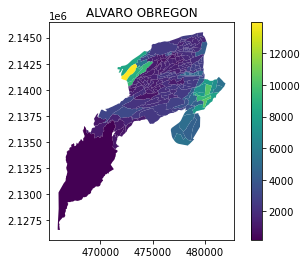

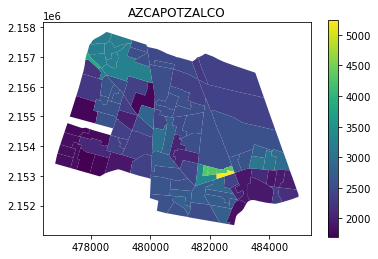

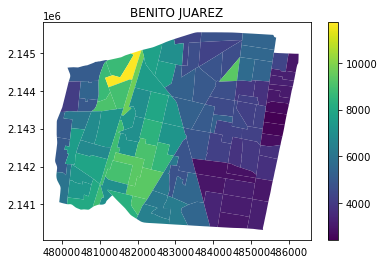

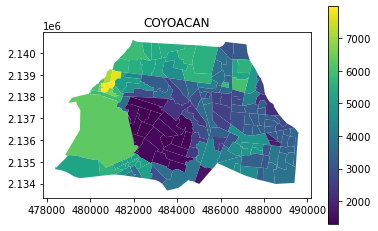

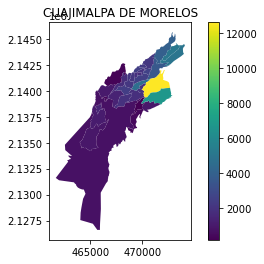

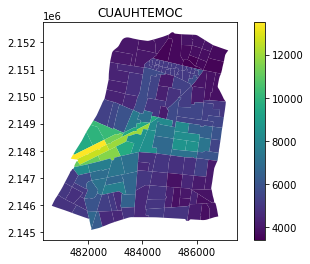

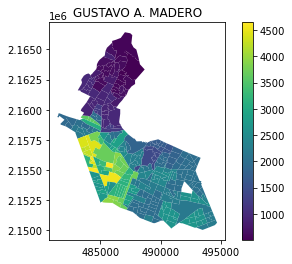

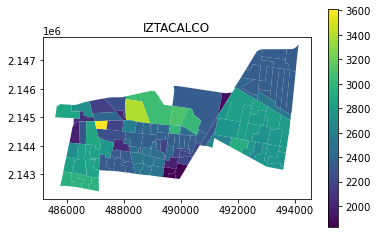

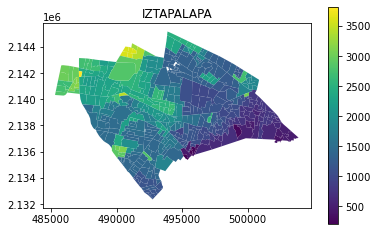

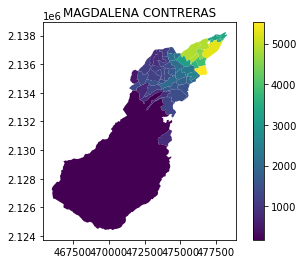

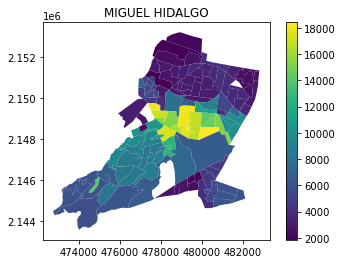

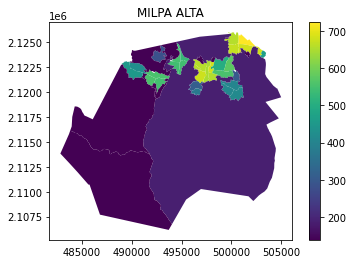

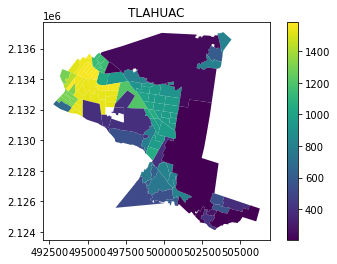

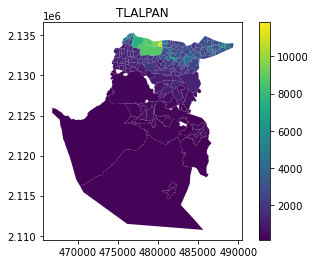

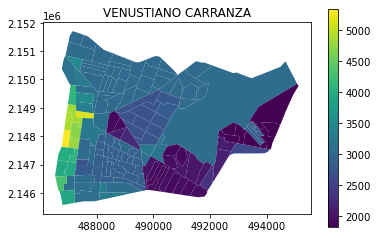

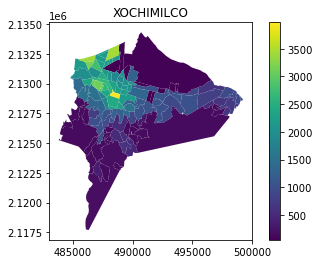

In [14]:
for i in f:
    name=i.split('\\')[1][:-8].replace('_',' ')
    
    gdf = gpd.read_file(i)
    
    gdf.plot(column='valor_unit',legend=True)
    plt.title(name) 

In [15]:
c = 0
for i in tqdm(f):
    if c==0:
        c+=1
        gdf = gpd.read_file(i)
    else:
        gdf = gdf.append(gpd.read_file(i))

gdf.to_file('Data/CDMX_AGEB/cdmx_cat.shp')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 21.19it/s]


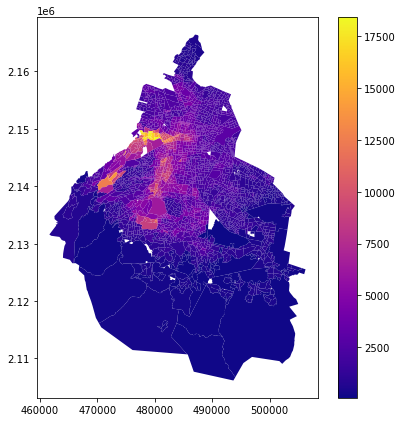

In [22]:
gdf.plot(column='valor_unit',figsize=(7,7),legend=True,cmap='plasma');

In [32]:
print('Total de agebs analizados: ',len(gdf))

Total de agebs analizados:  2415


In [31]:
csv= glob('Data/*.csv')

In [30]:
tot=0
for i in csv: #Creamos un ciclo para dar tratamiento a los datos en crudo, lo que se hizo fue extraer los datos que nos sirven para  el proyecto e  indicar el tipo de dato que es; es decir diferenciar entre los valores que son palabaras y  los que son números, es importante ya que así podremos realizar operaciones matematicas. 
    name = i[14:-12]
    df= pd.read_csv(i, usecols= ['fid','codigo_postal','superficie_terreno','valor_unitario_suelo','geo_shape','colonia_predio','anio_construccion'],
                    dtype= {'fid':str,'codigo_postal':str,'superficie_terreno':float,'valor_unitario_suelo':float,'geo_shape':str,'colonia_predio':str,'anio_construccion':float})
    ld = len(df)
    
    print('{}: {}\n*********'.format(name,ld))
    
    tot+=ld
    
print('Total de predios analizados: ',tot)

ALVARO OBREGON: 180236
*********
AZCAPOTZALCO: 117590
*********
BENITO JUAREZ: 251934
*********
COYOACAN: 173295
*********
CUAJIMALPA DE MORELOS: 69131
*********
CUAUHTEMOC: 257316
*********
GUSTAVO A. MADERO: 258038
*********
IZTACALCO: 103854
*********
IZTAPALAPA: 389890
*********
MAGDALENA CONTRERAS: 42969
*********
MIGUEL HIDALGO: 187264
*********
MILPA ALTA: 13071
*********
TLAHUAC: 74768
*********
TLALPAN: 168260
*********
VENUSTIANO CARRANZA: 123573
*********
XOCHIMILCO: 67182
*********
Total de predios analizados:  2478371
